In [23]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn import datasets

import warnings

warnings.filterwarnings("ignore")

# Import the dataset

In [24]:
data = datasets.load_iris()
iris = pd.DataFrame(data.data, columns=data.feature_names)

In [25]:
iris['species'] = data.target

## Rename the columns

In [26]:
iris = iris.rename(columns={'sepal length (cm)':'sl',
                            'sepal width (cm)':'sw',
                            'petal length (cm)':'pl',
                            'petal width (cm)':'pw'})

iris

,sl,sw,pl,pw,species
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2
146,6.3,2.5,5.0,1.9,2
147,6.5,3.0,5.2,2.0,2
148,6.2,3.4,5.4,2.3,2


# <span style="color:#B22222;">Logistic regression:</span> Two classes, one input 

## Select versicolor and virginica

In [27]:
iris_2species = iris[ (iris.species==1) | (iris.species==2) ]

## Training data set

In [28]:
X = iris_2species[['pl']]
y = iris_2species['species']

## Run logistic regression

In [29]:
lr = LogisticRegression().fit(X, y)

## Inspect the coefficients

In [30]:
logreg_beta0 = lr.intercept_[0]
logreg_beta1 = lr.coef_[0,0]
logreg_thresh = -logreg_beta0/logreg_beta1

(logreg_beta0, logreg_beta1, logreg_thresh)

(-17.50904699738906, 3.5908268927965428, 4.87604875426144)

## Compare to approximate values

In [31]:
X1 = X[y==1].to_numpy()
X2 = X[y==2].to_numpy()

mu1 = np.mean(X1)
mu2 = np.mean(X2)

var1 = np.var(X1)
var2 = np.var(X2)

var = np.mean((var1,var2))

approx_beta1 = (mu2-mu1)/var
approx_beta0 = (mu1**2 - mu2**2)/2/var
approx_thresh = -approx_beta0/approx_beta1

(approx_beta0, approx_beta1, approx_thresh)

(-24.62070787110408, 5.0184891706286345, 4.906)

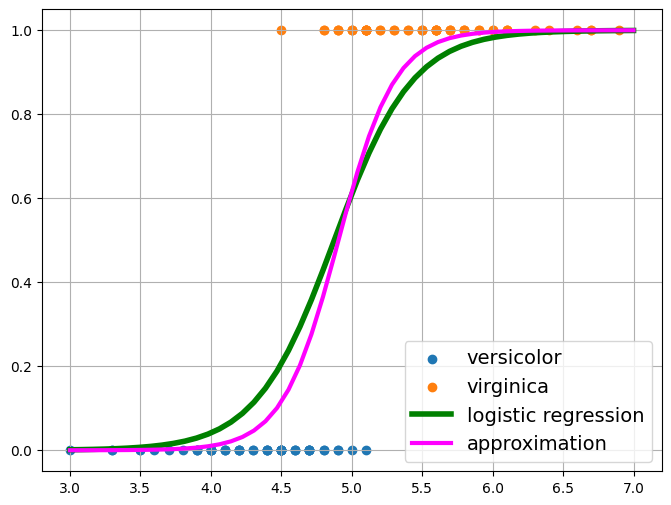

In [32]:
def sigmoid(beta0,beta1,x):
    return 1/(1+np.exp(-beta0 - beta1*x))

x = np.linspace(3,7)

plt.figure(figsize=(8,6))
plt.scatter( X1, np.zeros(50), label='versicolor' )
plt.scatter( X2, np.ones(50), label='virginica' )
plt.plot(x, sigmoid(logreg_beta0,logreg_beta1,x), linewidth=4, color='green',   label='logistic regression')
plt.plot(x, sigmoid(approx_beta0,approx_beta1,x), linewidth=3, color='magenta', label='approximation')
plt.legend(fontsize=14)
plt.grid()

# <span style="color:#B22222;">Logistic regression:</span> Two classes, two inputs

In [33]:
X = iris_2species[['pl','pw']].values
y = iris_2species['species'].values - 1

In [34]:
lr = LogisticRegression().fit(X, y)

lr.intercept_, lr.coef_

(array([-17.5471049]), array([[2.77743512, 2.38548149]]))

## Plot the regions

In [35]:
def plot_region(lr,d1lim,d2lim):
    d1_grid, d2_grid = np.meshgrid(np.arange(d1lim[0], d1lim[1], 0.02), np.arange(d2lim[0], d2lim[1], 0.02))
    d12_array = np.c_[d1_grid.ravel(), d2_grid.ravel()]
    y_array = lr.predict(d12_array)
    y_grid = y_array.reshape(d1_grid.shape)
    plt.contourf(d1_grid, d2_grid, y_grid, cmap='Pastel2')

Text(0, 0.5, 'petal width')

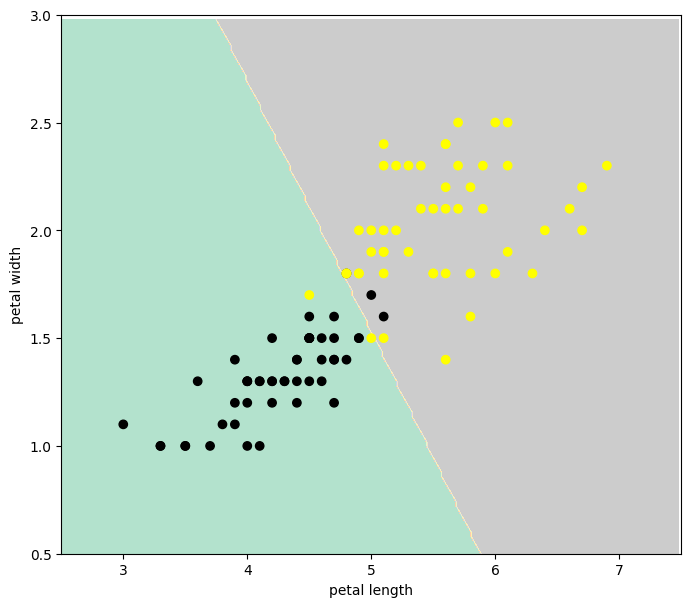

In [36]:
plt.figure(figsize=(8,7))

# plot the two regions
plot_region(lr, d1lim=(2.5, 7.5), d2lim=(0.5, 3.0))

# Data with a scatter plot
plt.scatter(x=iris_2species['pl'], 
            y=iris_2species['pw'],
            c=iris_2species['species'].map({1:'black', 2:'yellow'}))

plt.xlim(2.5, 7.5)
plt.ylim(0.5, 3.0)

plt.xlabel('petal length')
plt.ylabel('petal width')

# <span style="color:#B22222;">Logistic regression:</span> Three classes, two inputs

In [37]:
X = iris.loc[:,['pl','pw']].values
y = iris.loc[:,'species'].values

## One-vs-Rest

In [38]:
lr = LogisticRegression(multi_class='ovr').fit(X, y)

(0.0, 3.0)

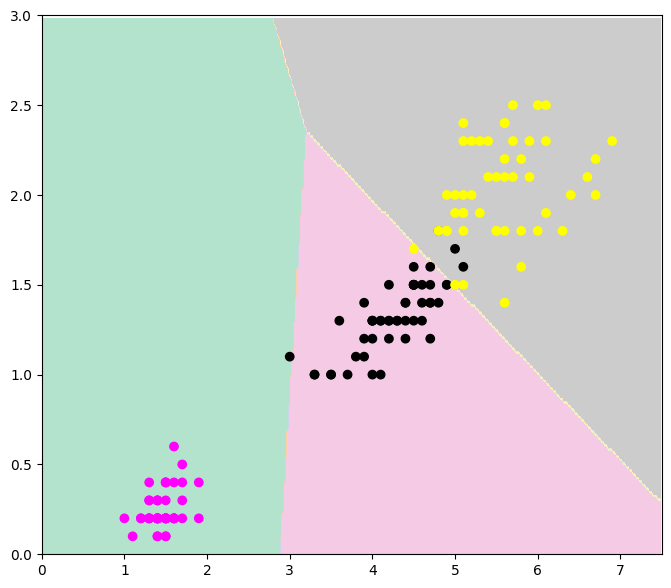

In [39]:
plt.figure(figsize=(8,7))

# plot the three regions
plot_region(lr, d1lim=(0, 7.5), d2lim=(0, 3.0))

# Data with a scatter plot
plt.scatter(x=iris.loc[:,'pl'], 
            y=iris.loc[:,'pw'],
            c=iris.loc[:,'species'].map({0:'magenta',1:'black', 2:'yellow'}))

plt.xlim(0, 7.5)
plt.ylim(0, 3.0)

## Multinomial

In [40]:
lr = LogisticRegression(multi_class='multinomial').fit(X, y)

(0.0, 3.0)

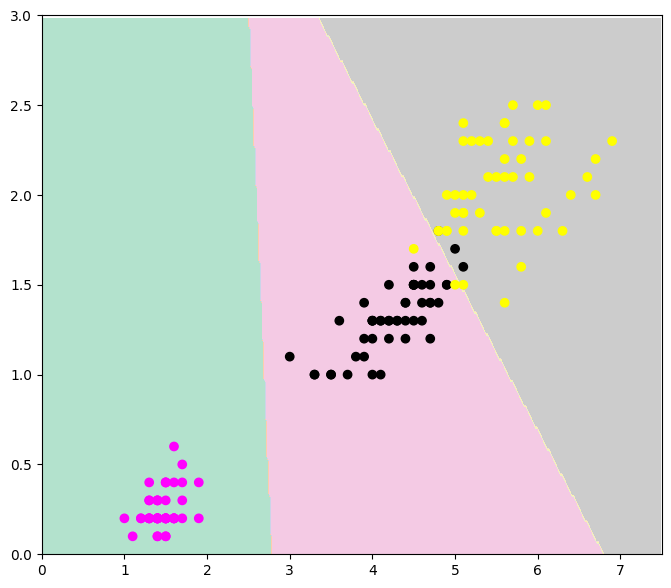

In [41]:
plt.figure(figsize=(8,7))

# plot the three regions
plot_region(lr, d1lim=(0, 7.5), d2lim=(0, 3.0))

# Data with a scatter plot
plt.scatter(x=iris.loc[:,'pl'], 
            y=iris.loc[:,'pw'],
            c=iris.loc[:,'species'].map({0:'magenta',1:'black', 2:'yellow'}))

plt.xlim(0, 7.5)
plt.ylim(0, 3.0)

# <span style="color:#B22222;">Logistic regression:</span> Feature selection via L1 regularization

In [42]:
X = iris_2species.iloc[:,:4]
y = iris_2species.iloc[:,-1] 

In [43]:
C = np.logspace(-1.2,-0.5)

coef = np.empty((len(C),4))
for i, c in enumerate(C):
    lr = LogisticRegression(penalty='l1', C=c, solver='liblinear').fit(X, y)
    coef[i] = lr.coef_

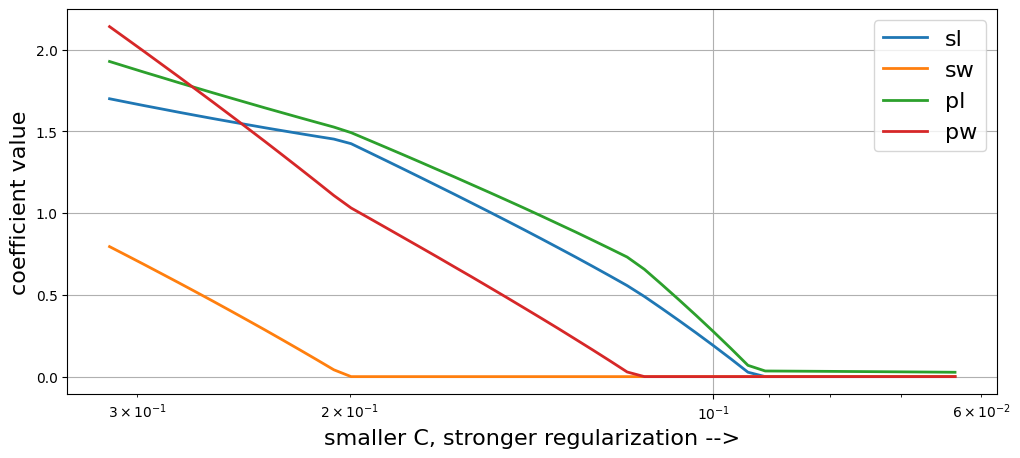

In [44]:
plt.figure(figsize=(12,5))
plt.semilogx(C,abs(coef),linewidth=2)
plt.gca().invert_xaxis()
plt.grid()
plt.legend(X.columns,fontsize=16)
plt.xlabel('smaller C, stronger regularization -->' , fontsize=16)
plt.ylabel('coefficient value', fontsize=16)
plt.show()